# DC2 Run1.2 object catalog number density
<br> Kernel: **desc-pyspark**
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-12-04**
    
The goal of this notebook is to compare the obseved galactic number density to the expected one.
The latter is provided by Rachel's formula N(mag_i<ilim)~40 x 10^(0.36 (ilim-25)) /sq arcmin (in the [24,25] range and was used to calibrate the simulation.
Here we use ilim=24.

# reading the data

In [1]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

df_all=spark.read.parquet("/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet")

#put in cache only relevant quantities
cols=["tract","patch","ra","dec","good","clean","extendedness"]
filters=['i']
for f in filters:
    s="psFlux_flag_{0},psFlux_{0},mag_{0},mag_{0}_cModel,snr_{0}_cModel".format(f)
    cols+=s.split(',')
print(cols)

df=df_all.select(cols)
N=df.cache().count()
df.printSchema()
print("#galaxies={} millions".format(N/1e6))


spark session started
['tract', 'patch', 'ra', 'dec', 'good', 'clean', 'extendedness', 'psFlux_flag_i', 'psFlux_i', 'mag_i', 'mag_i_cModel', 'snr_i_cModel']
root
 |-- tract: long (nullable = true)
 |-- patch: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- good: boolean (nullable = true)
 |-- clean: boolean (nullable = true)
 |-- extendedness: double (nullable = true)
 |-- psFlux_flag_i: boolean (nullable = true)
 |-- psFlux_i: double (nullable = true)
 |-- mag_i: double (nullable = true)
 |-- mag_i_cModel: double (nullable = true)
 |-- snr_i_cModel: double (nullable = true)

#galaxies=27.083536 millions


# Sky fraction and expected density

we estimate the sky fraction by projecting data onto a healpix map

In [2]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=2048
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()

#back to python world
map_p=df_map.toPandas()

#now data is reduced create the healpy map
map_c = np.zeros(hp.nside2npix(nside))
map_c[map_p['ipix'].values]=map_p['count'].values

<Figure size 432x288 with 0 Axes>

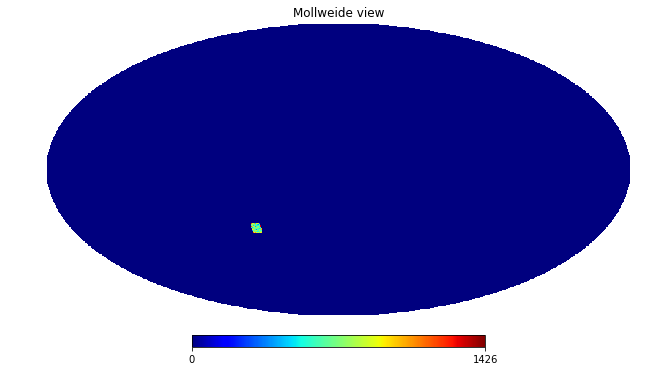

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet') #color-blind people should comment this line

hp.mollview(map_c)

compute the sky fraction and area

In [6]:
frac=np.sum(map_c!=0)/hp.nside2npix(nside)
A=frac*41253
print("fraction of the sksy={} total area={} deg^2".format(frac,A))

fraction of the sksy=0.0007590055465698242 total area=31.31125581264496 deg^2


so that the expected Nnumber for ilim=24 is

In [7]:
Nexp=40*10**(-0.36)*A*3600
print(Nexp)

1968171.6800939688


# Catalog analysis

histograms with spark

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

def minmax(df,col):
    return df.select(F.min(col),F.max(col)).first()

def histo(df,col,Nbins,bounds=None):
    if (bounds==None) :
        m=minmax(df,col)
        zmin=minmax[0]
        zmax=minmax[1]
    else:
        zmin=bounds[0]
        zmax=bounds[1]
        df=df.filter(df[col].between(zmin,zmax))
    
    dz=(zmax-zmin)/Nbins
    zbin=df.select(df[col],((df[col]-zmin-dz/2)/dz).cast(IntegerType()).alias('bin'))
    h=zbin.groupBy("bin").count().orderBy(F.asc("bin"))
    h=h.select("bin",(zmin+dz/2+h['bin']*dz).alias('loc'),"count").drop("bin")
    h=h.toPandas()
    step=(zmax-zmin)/Nbins
    plt.bar(h['loc'].values,h['count'].values,step,color='w',edgecolor='k')
    plt.xlabel(col)
    return h

quality cuts

In [10]:
df24=df.filter((df.mag_i_cModel<24) & (df.good==True) & (df.extendedness>0.9))

In [11]:
N=df24.count()
print("N(mag_i)<24={}".format(N))

N(mag_i)<24=985414


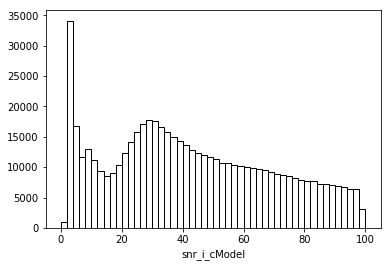

In [81]:
h=histo(df24,'snr_i_cModel',50,bounds=(0,100))

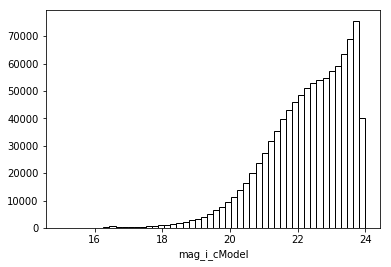

In [76]:
h=histo(df24,'mag_i_cModel',50,bounds=(15,24))